# Experimenting Facenet Pretrained Model

In [115]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [116]:
device = torch.device("cpu")

if torch.cuda.is_available():
   print("Training on GPU")
   device = torch.device("cuda:0")

Training on GPU


In [117]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
from torch.optim import Adam
from sklearn.metrics import accuracy_score, confusion_matrix

from model import *

In [118]:
torch.manual_seed(42)

In [119]:
transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]).to(device)
])

In [120]:
# data_dir = 'data/real_and_fake_face'

full_dataset = datasets.ImageFolder(root=data_dir, transform=transforms)

In [121]:
train_split = 0.8

train_size = int(train_split * len(full_dataset))
test_size = len(full_dataset) - train_size

train_data, test_data = random_split(full_dataset, [train_size, test_size])

In [122]:
train_data_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_data_loader = DataLoader(test_data, batch_size=32, shuffle=False)

In [123]:
class_map = full_dataset.class_to_idx
print(class_map)

{'training_fake': 0, 'training_real': 1}


In [124]:
model = FacenetFineTuned(pretrained='casia-webface').to(device)

  0%|          | 0.00/111M [00:00<?, ?B/s]

In [125]:
criterion = nn.BCEWithLogitsLoss()
optimizer = Adam(model.parameters())

In [126]:
# TRAIN LOOP
EPOCHS = 20
loss_list = []
for epoch in range(EPOCHS):
    running_loss = 0
    for image, label in train_data_loader:
        image = image.to(device)
        label = label.to(device)

        optimizer.zero_grad()

        outputs = model(image)

        loss = criterion(outputs, label.unsqueeze(1).float())

        loss.backward()

        optimizer.step()

        running_loss += loss.item()

    loss_list.append(running_loss/len(train_data_loader))
    print(f"Epoch {epoch + 1}/{EPOCHS}: Loss: {running_loss/len(train_data_loader)}")

Epoch 1/20: Loss: 0.6926685524921791
Epoch 2/20: Loss: 0.6914075063724144
Epoch 3/20: Loss: 0.68994773719825
Epoch 4/20: Loss: 0.69057984679353
Epoch 5/20: Loss: 0.6887218508065915
Epoch 6/20: Loss: 0.687284342214173
Epoch 7/20: Loss: 0.6856198369287977
Epoch 8/20: Loss: 0.6834726310243794
Epoch 9/20: Loss: 0.6835816455822364
Epoch 10/20: Loss: 0.6797653915835362
Epoch 11/20: Loss: 0.6802152021258485
Epoch 12/20: Loss: 0.6771754236782298
Epoch 13/20: Loss: 0.6759820253241295
Epoch 14/20: Loss: 0.6758287958070344
Epoch 15/20: Loss: 0.6718693048346276
Epoch 16/20: Loss: 0.6723285235610663
Epoch 17/20: Loss: 0.6714606565587661
Epoch 18/20: Loss: 0.6703368507179559
Epoch 19/20: Loss: 0.6649393906780318
Epoch 20/20: Loss: 0.666903956263673


In [127]:
PATH = 'facenetfinetuned.pth'

torch.save(model.state_dict(), PATH)

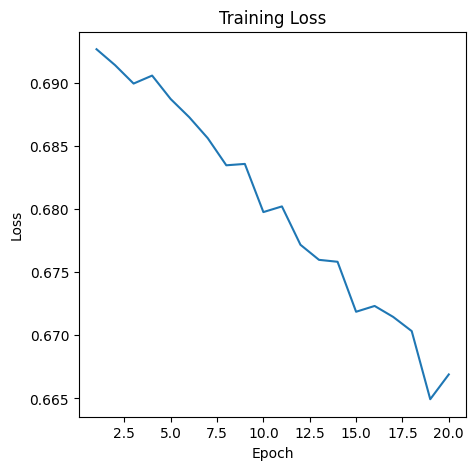

In [129]:
plt.figure(figsize=(5, 5))
plt.plot(list(range(1, 21)), loss_list)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [130]:
model.eval()

pred_labels = []
true_labels = []

for image, label in test_data_loader:

    image = image.to(device)
    label = label.to(device)

    outputs = model(image)
    outputs_proba = torch.sigmoid(outputs)
    outputs_class = (outputs_proba > 0.5).to(torch.int)

    true_labels.extend(label.cpu().numpy())
    pred_labels.extend(outputs_class.squeeze().cpu().numpy())


accuracy = accuracy_score(true_labels, pred_labels)
print(f"Model test accuracy: {accuracy:.4f}")

Model test accuracy: 0.5892


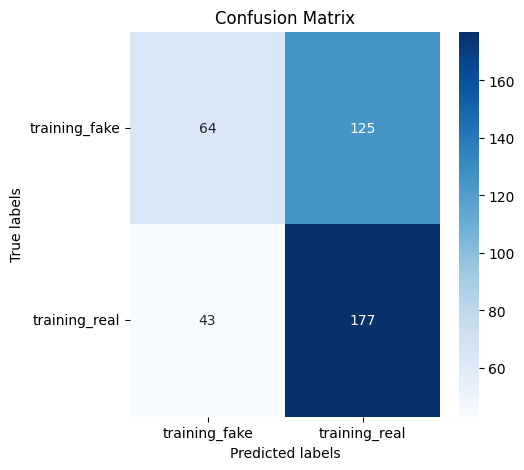

In [131]:
class_map = full_dataset.class_to_idx
class_mapping = {v: k for k, v in class_map.items()}

true_class_names = [class_mapping[x] for x in true_labels]
pred_class_names = [class_mapping[x] for x in pred_labels]

conf_mat = confusion_matrix(true_class_names, pred_class_names, labels=list(class_mapping.values()))

plt.figure(figsize=(5, 5))
sns.heatmap(conf_mat, annot= True, fmt='d', cmap='Blues', xticklabels=list(class_mapping.values()), yticklabels=list(class_mapping.values()))
plt.yticks(rotation=0)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()